In [1]:
__author__ = 'rmohammed'
#
import numpy as np               # Numpy library
from PIL import Image as im      # Basic image processing library 

### Line (ray) equation 

The ray equation is given by:

$$
\begin{align}
    {\bf p}\left(t\right) = {\bf e} + {\bf d} t,
\end{align}
$$
where: 
$$
\begin{align}
    {\bf d}  = {\bf s} - {\bf e}.
\end{align}
$$


![](ray.jpg)

The diagram shows the main components of the 3-D scene (and virtual camera), i.e.: 

- ${\bf e} \in \mathbb{R}^3$ is the eye location (i.e., viewer)

- ${\bf s} \in \mathbb{R}^3$ is a point on the image plane

- ${\bf d} \in \mathbb{R}^3$ is the ray direction

- $f \in \mathbb{R}$ is the focal distance (i.e., perpendicular distance between the center of projection and the image plane. 




In [2]:
class Ray:
    """
    A class representing a ray (line in space). 
    
    Uses the parametric representation of a line, p(t) = e + (s - e)*t.
    
    The ray passes through the following two points: 

    e = [e_u, e_v, e_w] representing the eye location in 3-D, and      
    s = [e_u, e_v, e_w] representing a point on the image plane.

    Attributes:
        e: 3x1 np.array, e.g., 
        s: 3x1 np.array 
    """

    def __init__(self, s):
        """
        Constructor method

        Args:
            e (3x1 np.array): Eye location
            s (3x1 np.array): Point on the image plane
        """
        self.e = np.array((0.0, 0.0, 0.0)).transpose()
        self.s = s   


    def get3DPoint(self, t):        
        """
        Calculates the location of a 3-D point along the ray given
        Args:
            t (float): Parameter of the ray equation
        Returns:
            p (3x1 nd.array): Point p(t) = e + (s - e) * t.
        """
        p = self.e + (self.s - self.e) * t    # p(t) = e + (s - e) * t
        
        return p

### Sphere equation 

The sphere equation in vector form is given by:

$$
\begin{align}
    \left({\bf p} - {\bf c}\right)\cdot \left({\bf p} - {\bf c}\right) - r^2 = 0,
\end{align}
$$

where ${\bf c} \in \mathbb{R}^3$ is the center of the sphere. 

#### Ray-sphere intersection
First, we substitute the ray equation into the sphere equation, i.e.: 

$$
\begin{align}
    \left({\bf e} + {\bf d}\,t - {\bf c}\right)\cdot \left({\bf e} + {\bf d}\,t - {\bf c}\right) - r^2 = 0. 
\end{align}
$$

Then, we expand the dot product (similarly to using the distributive property in multiplication) and re-arrange the terms to obtain: 

$$
\begin{align}
    \underbrace{\left({\bf d}\cdot {\bf d}\right)}_{A}t^2 + \underbrace{2\,{\bf d}\cdot\left({\bf e} - {\bf c}\right)}_{B}\,t + \underbrace{\left({\bf e} - {\bf c}\right) \cdot \left({\bf e} - {\bf c}\right) - r^2}_{C} = 0, 
\end{align}
$$

which is the classic quadratic equation: 

$$
\begin{align}
    {A}t^2 + {B}\,t + {C} = 0. 
\end{align}
$$

Its solution for t is given by: 

$$
\begin{align}
    t = \frac{-B\pm\sqrt{B^2-4AC}}{2A}. 
\end{align}
$$







In [3]:
class Sphere:
    """
    A class representing a Sphere.

    Attributes:
        Center (3x1 np.ndarray): Center of the sphere in 3-D
        Radius (float): Radius of the sphere
        Color (3x1 np.ndarray): (Solid) Color of the sphere's surface Color = [ red, green, blue]
    """
    
    def __init__(self, c, r, k):
        """
        Constructor method

        Args:
            c (3x1 np.ndarray): Center 
            r (float): Radius
            k (3x1 np.ndarray): Color [red, green, blue], each component is in the [0,255] range            
        """
        self.center = c
        self.radius = r
        self.color = k

    def Intersect(self, ray):
        """
        Calculates the intersection of this sphere and the ray provided as input

        Args:
            ray (Ray object)  p(t) = e + (s - e) * t
        Returns:
            t (float): distance (line parameter) from the eye to the intersection point along the ray
        """

        # For calculations, I prefer to use the notation
        # similar to the one in the slides or associated paper.
        
        d = ray.s - ray.e  # Direction of the ray
        e = ray.e          # Ray's starting point

        c = self.center  # Sphere center
        r = self.radius  # Sphere radius

        # Check whether the ray intersects the sphere
        A = np.dot(d, d)
        B = 2.0 * np.dot(d, (e - c))
        C = np.dot((e - c), (e - c)) - r * r

        #delta = B*B - A * C
        delta = B*B - 4.0 * A * C
        
        if delta < 0:
            return float("inf")         # Ray didn't intersect sphere
        else:
            # Compute value of parameter t at the intersection point
            t1 = (-B - np.sqrt(delta)) / (2.0 * A)
            t2 = (-B + np.sqrt(delta)) / (2.0 * A)

            # We are interested only in the closest intersection.
            # We take the smaller t
            t = np.min([t1, t2])
            
            return t
    def get_normal(self, p):
        """ 
        Calculates the surface normal at the point p on the sphere. 
            It assumes that p is on the sphere!!!
        Args:
            p (3x1 np.ndarray): 3-D point on the sphere 
        Returns:
            n (3x1 np.ndarray): Normalized (unit) normal vector at point p
        """
        
        n = (p - self.center) / np.linalg.norm(p - self.center)
        
        return n  

### Converting between image-plane coordinates and image-matrix indices

When creating the rays we need to take into account that the coordinates (i.e., indices) of the image matrix are $(i,j)$ and the coordinates of the image plane are $(u,v)$.  

We also need to remember that the origin of the $(u,v)$-system is at the center of the plane while the origin of the image matrix is (usually) at the top-left corner. 

As a result, we must convert between geometric $(u,v)$ coordinates and matrix indices $(i,j)$. 

![](uv_ij.jpg)



In [4]:
class Camera:
    """
    A class representing the camera.
    
    This camera consists of the focal length, the image matrix, and functions 
    that convert pixel coordinates to geometric (u,v,w)-coordinates. 

    Attributes:
        f (float): Camera's focal distance
        
        nrows (int): Image horizontal resolution in pixels 
        ncols (int): Image vertical resolution in pixels 
        I (np.ndarray of size nrows x ncols)
    """        
    def __init__(self, f, nrows, ncols, nchannels):
        # f: Focal distance 
        self.f = f         
        self.nrows = nrows    # Image resolution in pixels 
        self.ncols = ncols
        
        # Number of color channels
        self.nchannels = nchannels    # channels (RGB)

        # Initialize image matrix 
        self.I = np.zeros([self.nrows, self.ncols, self.nchannels])

    'Ray-sphere intersection. It returns the smallest t. '
    def ij2uv(self, i, j):
        u =  (j + 0.5) - self.ncols/2 
        v = -(i + 0.5) + self.nrows/2
        
        return u,v

    def constructRayThroughPixel(self, i, j):
        # Construct ray through pixel (i,j)
        u,v = self.ij2uv(i, j)
        s = np.array((u, v, -self.f)).transpose()
        ray = Ray(s)                        

        return ray
    


In [5]:
class HitInformation:
    """A class representing the all the information of objects intersected by a given ray.

    Attributes:
        Object (python class of object): e.g., sphere, cylinder, cone, plane
        
        p (3x1 np.ndarray): 3-D coordinates of the intersection point 
    """
    def __init__(self, intersected_object, intersecton_point):
        self.Object = intersected_object
        self.p = intersecton_point
        
     

In [6]:
class Scene: 
    """
    A class representing the whole scene, i.e., objects in the scene.

    I wanted Scene to consist of the entire scene that consists of 
    all objects (e.g., spheres, planes, triangles, cilinders). 
    
    Here is just a preliminary attempt of implementing a list of objects.         

    Attributes:
        Object (python class of object): e.g., sphere, cylinder, cone, plane
        
        p (3x1 np.ndarray): 3-D coordinates of the intersection point 
    """
    
    light_source = np.array([2,2,2])
    light_source = light_source / np.linalg.norm(light_source)
    
    
    def __init__(self, the_camera, scene_objects):
        
        self.the_camera = the_camera   # I think I need the camera because it has the eye location 

        # List of objects in the scene 
        self.scene_objects = scene_objects
           
    def find_intersection(self, ray):
        """
        Intersects the ray with the scene (all objects in the scene)

        Args:
            ray (Ray object)  p(t) = e + (s - e) * t
        Returns:
            hit (python list): list with the information about the hits.
        """
        hit_list = []        # List of intersections (location and object intersected)
        for surface in self.scene_objects: 
            t = surface.Intersect(ray)                  # t parameter at intersection point
            if float('inf') != t:                       # Does the ray intersects the surface? 
                p = ray.get3DPoint(t) 
                hitInfo = HitInformation(surface, p)
                hit_list.append(hitInfo)                     # We might need more attributes...

        return hit_list     # List with the information about the hits
    
    def phong(self, p, n, color, e):
        # Calculate diffuse shading
        diffuse_shading = self.calculate_diffuse_shading(n, color)

        # Calculate ambient light component
        ambient_color = self.calculate_ambient_color(color)

        # Calculate specular component
        specular_component = self.calculate_specular_component(p, n, color, e)

        # Color of the intersected object (at the intersection point)
        return ambient_color + diffuse_shading + specular_component

    def calculate_diffuse_shading(self, n, color):
        dot_product = np.dot(self.light_source, n)
        max_dot_product = max(0, dot_product)
        return color * max_dot_product

    def calculate_ambient_color(self, color):
        return color * 0.1

    def calculate_specular_component(self, p, n, color, e):
        v = e - p
        v_norm = np.linalg.norm(v)
        v_norm = v / v_norm

        h = v_norm + self.light_source
        h_norm = np.linalg.norm(h)
        h_norm = h / h_norm

        dot_product = np.dot(h_norm, n)
        max_dot_product = max(0, dot_product)
        return color * max_dot_product ** 128

    def get_color(self, hit_list, ray):
        """
        Returns the color seen by the visual ray. This is the sum of all colors weighted by their shading.
        """
        total_color = np.array([0.0, 0.0, 0.0])
        num_hits = len(hit_list)

        for hit in hit_list:
            intersection_point = hit.p
            object_normal = hit.Object.get_normal(intersection_point)
            object_color = hit.Object.color
            shading = self.phong(intersection_point, object_normal, object_color, ray.e)
            total_color += shading

        pixel_color = total_color / num_hits if num_hits > 0 else np.array([0.0, 0.0, 0.0])
        return pixel_color

        
                

### Basic ray-tracing/ray-casting algorithm

The basic algorithm for ray tracing is given by: 

![](./algorithm.jpg)

In [7]:
def rayCast(my_camera, the_scene, nrows, ncols):

    # Loop through all pixels (i,j) in the image matrix 
    for i in range(nrows): 
        for j in range(ncols):
            # Construct the ray between between the eye and s = (u, v, -f)       
            ray = my_camera.constructRayThroughPixel(i, j)

            # Intersect the ray with the scene (all objects in the scene)
            hit = the_scene.find_intersection(ray)   

            # Set the pixel color 
            my_camera.I[i,j,:] = the_scene.get_color(hit, ray)

    # Create an image from an array (display image and save file)
    out_image = im.fromarray(np.uint8(my_camera.I))
    out_image.save('raytraced_scene.png')
    
    return out_image

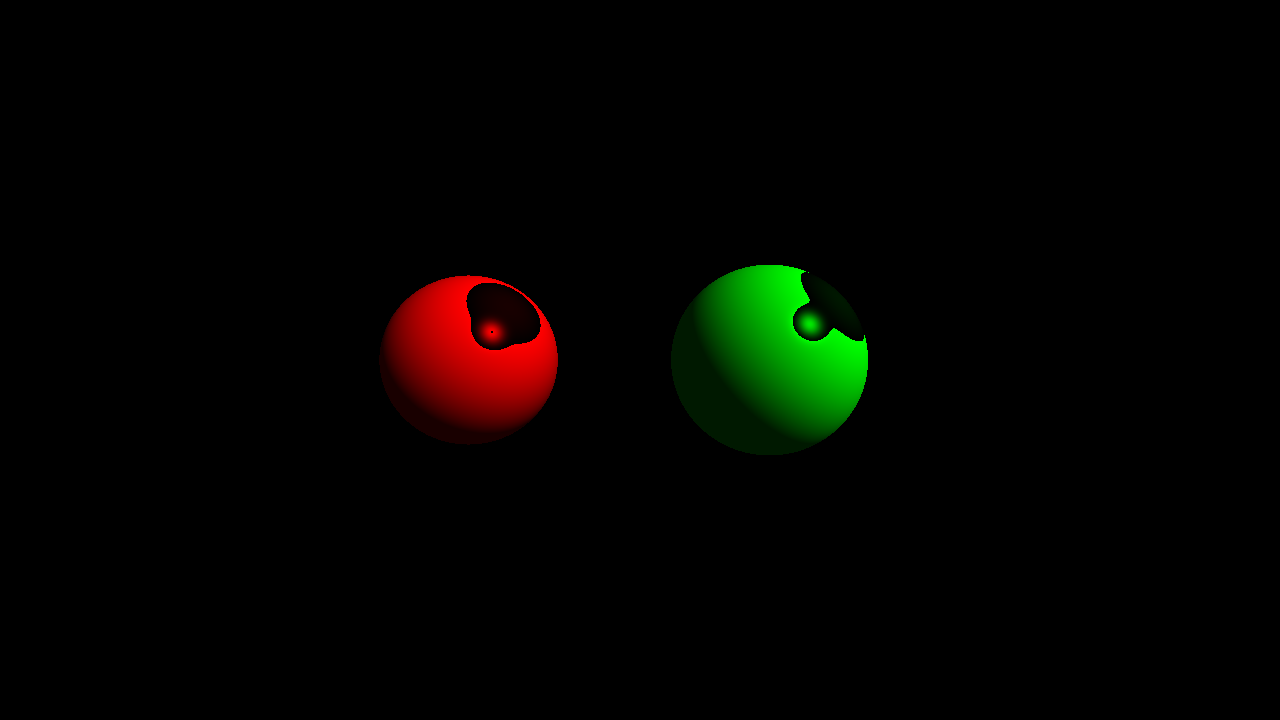

In [8]:
# Define camera properties and resolution
image_width = 1280
image_height = 720
num_channels = 3
focal_length = 500.0

# Create camera object
camera = Camera(focal_length, image_height, image_width, num_channels)

# Define objects in the scene
objects = []

# Object 1
center1 = np.array((-200.0, 0.0, -600.0)).transpose()
radius1 = 100.0
color1 = np.array((255, 0, 0)).transpose()
objects.append(Sphere(center1, radius1, color1))

# Object 2
center2 = np.array((200.0, 0.0, -800.0)).transpose()
radius2 = 150.0
color2 = np.array((0, 255, 0)).transpose()
objects.append(Sphere(center2, radius2, color2))

# Create the scene with the camera and objects
scene = Scene(camera, objects)

# Use ray casting to render the scene and display the image
display(rayCast(camera, scene, image_height, image_width))

### The plane equation 
The plane through ${\bf p}_1 = \left(u,v,w\right)^\mathsf{T}$, with surface normal ${\bf n} = \left(n_u,n_v,n_w\right)^\mathsf{T}$ is given by the following implicit equation: 

$$
\begin{align}
    \left({\bf p} - {\bf p}_1\right) \cdot {\bf n} = 0.
\end{align}
$$

#### Ray-plane intersection

The equation of the ray (line) between the eye and a point on the image plane is given by: 

$$
\begin{align}
    {\bf p}\left(t\right) = {\bf e} + {\bf d} t,
\end{align}
$$

where: 

$$
\begin{align}
    {\bf d}  = {\bf s} - {\bf e}.
\end{align}
$$

The intersection between the ray and a plane is the point ${\bf p}\left(t\right)$ for: 

$$
\begin{align}
    t = \frac{({\bf p}_1 - {\bf e}) \cdot {\bf n}}{{\bf d} \cdot {\bf n}}.
\end{align}
$$




In [9]:
class Plane:
    """
    A class representing a plane in 3D space.

    Attributes:
        point (3x1 np.ndarray): a point on the plane
        normal (3x1 np.ndarray): the plane's normal vector
        color (3x1 np.ndarray): the plane's color in RGB format
    """
    
    def __init__(self, point, normal, color):
        """
        Constructor method

        Args:
            point (3x1 np.ndarray): a point on the plane 
            normal (3x1 np.ndarray): the plane's normal vector
            color (3x1 np.ndarray): the plane's color in RGB format, each component is in the [0,255] range            
        """
        self.point = point
        self.normal = normal
        self.color = color
        
    def get_normal(self, point):
        """
        Returns the normal vector of the plane.

        Args:
            point (3x1 np.ndarray): any point on the plane

        Returns:
            3x1 np.ndarray: the normal vector of the plane
        """
        return self.normal

    def Intersect(self, ray):
        """
        Calculates the intersection of this plane and a given ray.

        Args:
            ray (Ray object): the ray to intersect with the plane

        Returns:
            float: the distance (line parameter) from the ray's starting point to the intersection point along the ray
        """
        direction = ray.s - ray.e
        starting_point = ray.e

        t = np.dot(self.point - starting_point, self.normal) / np.dot(direction, self.normal)

        return t

    

### Calculating the (unit) normal vector of a plane 

Select three non-colinear points, use these points to create two vectors on the plane, then calculate their cross product. Normalize the result to obtain the (unit) normal vector. 

![](./trinormal.jpg)

(Unit) normal vector to the plane: 

$$
{\bf n} = \frac{({\bf b} - {\bf a}) \,\times ({\bf c} - {\bf a})}
{\|({\bf b} - {\bf a}) \,\times ({\bf c} - {\bf a})\|} 
$$

C:\Users\Riad\AppData\Local\Temp/ipykernel_19788/3703825501.py:70: RuntimeWarning: invalid value encountered in true_divide
  v_norm = v / v_norm


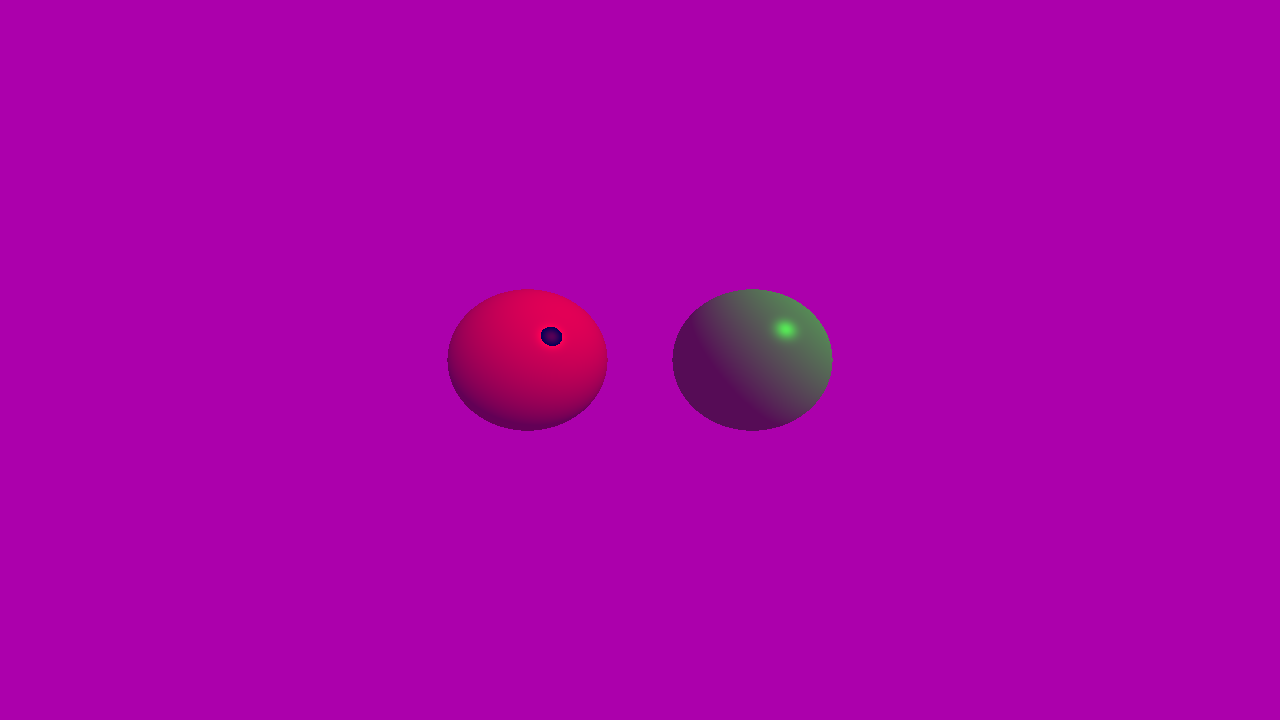

In [10]:
# Create camera (and image resolution)
nrows = 720
ncols = 1280
nchannels = 3

# Focal distance
f = 200.0

my_camera = Camera(f, nrows, ncols, nchannels)

# list of geometrical objects.
scene_objects = []

# Object 1
Center = np.array((-150.0, 0.0, -300.0)).transpose()
Radius = 100.0
Color = np.array((255, 0, 0)).transpose()
scene_objects.append(Sphere(Center, Radius, Color))

# Object 2
Center = np.array((150.0, 0.0, -300.0)).transpose()
Radius = 100.0
Color = np.array((0, 255, 0)).transpose()
scene_objects.append(Sphere(Center, Radius, Color))

# Object 3 (the plane)
p1 = np.array((0.0, 0.0, 2.0)).transpose()
n = np.array((0.0, 1.0, 0.0)).transpose()

Color = np.array((255, 0, 255)).transpose()
scene_objects.append(Plane(p1, n, Color))

# Create the scene (collection of objects - hardcoded for simplicity)
the_scene = Scene(my_camera, scene_objects)

display(rayCast(my_camera, the_scene, nrows, ncols))

### Diffuse shading

$$
    \text{shaded_color} = (r,g,b) * max(0, l \cdot n ) 
$$